In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [2]:
train_df = pd.read_csv('pa3_train_reduced.csv',names=[str(x) for x in range(101)],index_col=False)
X = train_df.iloc[:,:]
X["index"] = np.array(range(X.shape[0]))[:np.newaxis]


In [3]:
debug = 0

In [4]:
train_df.shape

(4888, 102)

In [5]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,index
0,5,-252.5092,1040.6188,-310.8433,-470.0898,-166.3477,330.8560,-108.7784,-175.5801,-260.2999,...,-141.7645,-78.5002,-49.8887,20.5103,-76.4562,-25.1281,-21.6094,-32.6020,25.6190,0
1,5,-684.5502,-368.7191,-288.2767,-429.0820,279.5500,277.4358,433.0551,324.3357,-244.7808,...,11.3478,-47.5631,-15.8404,25.0016,-29.7523,58.7726,-36.3467,26.6937,-17.5640,1
2,3,119.2934,638.9885,480.5071,-56.4139,268.1087,877.3390,144.2621,211.2293,-105.4375,...,31.8160,43.4647,29.9262,25.9335,37.2404,31.1867,14.7913,48.7926,-94.5664,2
3,5,992.5711,-204.1036,527.5170,-27.3539,-274.9326,-332.5300,-384.0204,198.4980,-92.0866,...,-16.4719,-103.3384,-15.5614,-71.7062,79.4549,-75.4443,-18.7221,76.8132,-11.6647,3
4,3,-750.9831,-11.7291,461.3095,128.3521,-335.1824,129.9351,191.3054,265.0773,265.4485,...,90.5645,-117.8963,78.7388,9.7614,-8.5616,-13.3530,-13.5420,-59.0314,-2.5690,4


In [6]:
class node:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = None
        self.value = None
        self.number = None
        self.count = None
        self.count_3 = None
        self.count_5 = None
        #self.indices = None

In [7]:
def calc_gini(k,total_count_3,total_count_5,till_now,x,UA):
    last_k = till_now[0]
    count_3_left = till_now[1]
    count_5_left = till_now[2]
    
    extra_5 = sum(x['c_5'][last_k:k])
    extra_3 = k-last_k - extra_5
    
    count_3_left += extra_3
    count_5_left += extra_5
    
    count_3_right = total_count_3 - count_3_left
    count_5_right = total_count_5 - count_5_left
    
    
    if debug==1:
        print(till_now,k)
    
    pa_3_left = count_3_left/(count_5_left+count_3_left)
    pa_5_left = count_5_left/(count_5_left+count_3_left)
    gini_left = 1-(pa_3_left*pa_3_left) - (pa_5_left*pa_5_left)
    
    pa_3_right = count_3_right/(count_5_right+count_3_right)
    pa_5_right = count_5_right/(count_5_right+count_3_right)
    gini_right = 1 -(pa_3_right*pa_3_right) - (pa_5_right*pa_5_right)
    
    prob_left = (count_3_left+count_5_left)/(total_count_3+total_count_5)
    prob_right = (count_3_right+count_5_right)/(total_count_3+total_count_5)
    
    benefit = UA - prob_left*gini_left - prob_right*gini_right
    if debug==1:
        print("UA=",UA,"prob left=",prob_left,"gini_left=",gini_left,"prob_right=",prob_right,"gini_right=",gini_right)
        print("total_count_5","total_count_3","count_5_left","count_3_left","count_5_right","count_3_right")
        print(total_count_5,total_count_3,count_5_left,count_3_left,count_5_right,count_3_right)
    till_now[0] = k
    till_now[1] = count_3_left
    till_now[2] = count_5_left
    
    if debug==1:
        print(till_now)
    if(UA>1):
        print("higher",UA,benefit)
    return benefit
def find_best_split_for_feature(X,ind):
    x = X[["0",ind,"index"]].sort_values(by=ind)
    x['x_index'] = range(x.shape[0])
    x.index = range(x.shape[0])
    total = x.shape[0]
    
   
    
    count_3 = x["0"].value_counts().sort_values().loc[3]
    count_5 = total - count_3
    
    if debug==1:
        print(x.shape)
        print(count_5,count_3)
        print(x["0"].value_counts().sort_values())
    till_now = list((0,0,0))
    
    p_3 = count_3/total
    p_5 = count_5/total
    UA = 1-(p_3*p_3)-(p_5*p_5)
    if debug ==1:
        print("UA=",UA)
    
    x['c_5'] = x["0"].apply(lambda k : 1 if k==5 else 0)
    if debug ==1:
        print(x)
        print(x["0"].value_counts().sort_values())
        print(count_3,count_5)
        print(till_now)
    x['gini'] = x['x_index'].apply(
                lambda k : calc_gini(k,count_3,count_5,till_now,x,UA) if k!=0 and  x['c_5'][k-1]!=x['c_5'][k] else 0)
    index_for_feature = x['gini'].idxmax()
    left = x['index'][:index_for_feature]
    right = x['index'][index_for_feature:]
    if debug ==1:
        print(x['gini'].value_counts())
        print(x['gini'].max(),x['gini'].idxmax(),till_now[1],till_now[2])
    return x['gini'][index_for_feature],left,right , x[ind][index_for_feature]
    #print(x['gini'])
    #print(x.head(30))
    

In [8]:
import time
def dfs(X):
    
    root = node()
    root.left = node()
    root.right = node()
    root.count_3 = X['0'].value_counts().loc[3]
    root.count_5 = X.shape[0] - root.count_3
    left = None
    right = None
    gini = -1
    feature = None
    value = None
    for k in range(1,100):
        g,l,r,v = find_best_split_for_feature(X,str(k))
        if g > gini:
            left = l
            right =  r
            gini = g
            feature = k
            value=v
        if((k%10)==0 and debug==1):
            print("done for k=",k/10)
            
    #print(len(left),len(right),feature,gini)
    root.feature = feature
    root.value = value
    X_left = X.loc[left]
    X_right = X.loc[right]
    L = X_left['0'].value_counts() 
    R = X_right['0'].value_counts()
    
    root.number = None
    if sum(L.index)==8:
        
        root.left = dfs(X_left)
        
    else:
        
        root.left.number = 5 if 3 not in L.index else 3
        root.left.count = X_left.shape[0]
        root.left.count_3 = L.loc[3] if 3 in L.index else 0
        root.left.count_5 = L.loc[5] if 5 in L.index else 0
        
    if sum(R.index)==8:
       
        root.right = dfs(X_right)
        
    else:
        
        root.right.number = 5 if 3 not in R.index else 3
        root.right.count = X_right.shape[0]
        root.right.count_3 = R.loc[3] if 3 in R.index else 0
        root.right.count_5 = R.loc[5] if 5 in R.index else 0
        
    return root

In [9]:
import time
a = time.clock()
root=dfs(X)
print(time.clock()-a)

897.3372125246511


In [10]:
sum(X['0'].value_counts().index)

8

In [11]:
def find_depth(root):
    if root.feature==None:
        return 0
    else:
        return max(find_depth(root.left),find_depth(root.right))+1
print(find_depth(root))

17


In [22]:
def calculate_accuracy(row,d,r,max_depth):
    if d==max_depth:
        cls = 3 if r.count_3>r.count_5 else 5
        return 1 if row['0']==cls else 0
    if r.feature==None:
        return 1 if r.number == row['0'] else 0
    
    if row[r.feature]<r.value:
        return calculate_accuracy(row,d+1,r.left,max_depth)
    else:
        return calculate_accuracy(row,d+1,r.right,max_depth)
    
#accuracy = X.apply(calculate_accuracy ,axis=1)
accuracy = 0
for k in range(X.shape[0]):
    accuracy +=calculate_accuracy(X.iloc[k,:],0,root,16)
print(accuracy)
print(accuracy/X.shape[0])

4887
0.9997954173486089


In [27]:
valid_df = pd.read_csv('pa3_valid_reduced.csv',names=[str(x) for x in range(101)],index_col=False)
val_X = valid_df.iloc[:,:]



In [29]:
val_X.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,5,772.1564,594.2686,99.9710,-676.2918,-90.0010,206.3271,-11.5424,-267.0666,-396.1290,...,-33.1565,47.5868,-43.3703,-41.4258,-20.5521,17.8180,-42.2400,-24.5414,-10.3573,-29.5430
1,5,76.7211,-1106.0831,-29.7846,-747.6476,-287.8957,-297.5735,319.3065,-109.8892,231.0944,...,-80.3236,88.4407,-51.6162,115.9922,125.8303,-24.4752,33.8021,159.0301,-43.1058,7.5995
2,5,429.3979,-905.2265,-614.4940,-109.9827,-146.0062,-117.9901,182.1199,-71.3458,566.5455,...,-37.2232,-92.2027,-17.1015,68.7367,44.1911,56.8847,-23.0728,-76.8863,-11.9458,-42.9588
3,5,586.4843,-544.0520,-890.3127,-138.1357,-172.0075,-103.9851,-506.5991,144.8151,-75.8075,...,33.0657,38.5038,14.2699,-159.4892,-12.5872,37.4185,-44.0055,-49.6762,16.4211,64.4715
4,3,223.6410,676.9856,-8.6808,116.7774,310.5443,775.8125,-61.4416,476.6346,44.6428,...,41.8437,-45.3246,42.4549,-7.3443,-0.8938,19.0755,79.6127,-19.7164,-21.8841,4.5540


In [15]:
accuracy=0
for k in range(Val_X.shape[0]):
    accuracy +=calculate_accuracy(Val_X.iloc[k,:],root)
print(accuracy/Val_X.shape[0])

0.9146715776550031


In [32]:
def calculate_depth_accuracy(X,depth):
    acc_mat = np.zeros((X.shape[0],depth))
    for d in range(depth):
        for i in range(X.shape[0]):
            acc_mat[i][d] = calculate_accuracy(X.iloc[i,:],0,root,d)
    acc_mat = np.mean(acc_mat,axis=0)
    return acc_mat


In [33]:
import time
t = time.clock()
train_accuracy_for_each_depth = calculate_depth_accuracy(X,18)
print(time.clock()-t)
print(train_accuracy_for_each_depth)
print(np.argmax(train_accuracy_for_each_depth))

70.05505010886827
[0.53621113 0.73711129 0.80626023 0.81751227 0.86886252 0.90998363
 0.92982815 0.950491   0.9646072  0.98036007 0.98833879 0.99304419
 0.9952946  0.99713584 0.99836334 0.99938625 0.99979542 1.        ]
17


In [34]:
import time
t = time.clock()
validation_accuracy_for_each_depth = calculate_depth_accuracy(val_X,18)
print(time.clock()-t)
print(validation_accuracy_for_each_depth)
print(np.argmax(validation_accuracy_for_each_depth))

23.571649450525
[0.53898097 0.72866789 0.79558011 0.80785758 0.85205648 0.88090853
 0.88766114 0.89809699 0.91467158 0.91958257 0.91712707 0.91896869
 0.91896869 0.9165132  0.91589932 0.91528545 0.91467158 0.91467158]
9


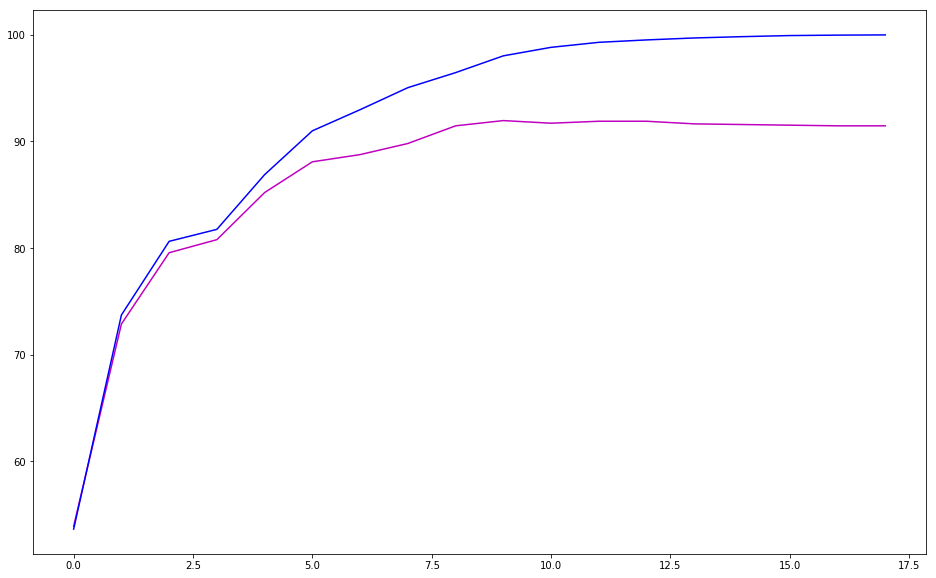

In [45]:
plt.figure(figsize=(16,10))
plt.plot(range(18),validation_accuracy_for_each_depth*100,color='m')
plt.plot(range(18),train_accuracy_for_each_depth*100,color='b')